<a href="https://colab.research.google.com/github/prashant-gulati/portfolio/blob/main/llm_decoding_strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reading in a short story as text sample into Python.

## Step 1: Creating Tokens

<div class="alert alert-block alert-success">

The print command prints the total number of characters followed by the first 100
characters of this file for illustration purposes. </div>

In [1]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        raw_text = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(raw_text)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        raw_text = file.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


<div class="alert alert-block alert-success">

Our goal is to tokenize this 20,479-character short story into individual words and special
characters that we can then turn into embeddings for LLM training  </div>

<div class="alert alert-block alert-warning">

Note that it's common to process millions of articles and hundreds of thousands of
books -- many gigabytes of text -- when working with LLMs. However, for educational
purposes, it's sufficient to work with smaller text samples like a single book to
illustrate the main ideas behind the text processing steps and to make it possible to
run it in reasonable time on consumer hardware. </div>

<div class="alert alert-block alert-success">

How can we best split this text to obtain a list of tokens? For this, we go on a small
excursion and use Python's regular expression library re for illustration purposes. (Note
that you don't have to learn or memorize any regular expression syntax since we will
transition to a pre-built tokenizer later in this chapter.) </div>

<div class="alert alert-block alert-warning">

Using some simple example text, we can use the re.split command with the following
syntax to split a text on whitespace characters:</div>

In [2]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


<div class="alert alert-block alert-info">
The result is a list of individual words, whitespaces, and punctuation characters:
</div>


<div class="alert alert-block alert-warning">

Let's modify the regular expression splits on whitespaces (\s) and commas, and periods
([,.]):</div>

In [3]:
result = re.split(r'([,.]|\s)', text)

print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


<div class="alert alert-block alert-info">
We can see that the words and punctuation characters are now separate list entries just as
we wanted
</div>


<div class="alert alert-block alert-warning">

A small remaining issue is that the list still includes whitespace characters. Optionally, we
can remove these redundant characters safely as follows:</div>

In [4]:
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


<div class="alert alert-block alert-success">

REMOVING WHITESPACES OR NOT


When developing a simple tokenizer, whether we should encode whitespaces as
separate characters or just remove them depends on our application and its
requirements. Removing whitespaces reduces the memory and computing
requirements. However, keeping whitespaces can be useful if we train models that
are sensitive to the exact structure of the text (for example, Python code, which is
sensitive to indentation and spacing). Here, we remove whitespaces for simplicity
and brevity of the tokenized outputs. Later, we will switch to a tokenization scheme
that includes whitespaces.

</div>

<div class="alert alert-block alert-warning">

The tokenization scheme we devised above works well on the simple sample text. Let's
modify it a bit further so that it can also handle other types of punctuation, such as
question marks, quotation marks, and the double-dashes we have seen earlier in the first
100 characters of Edith Wharton's short story, along with additional special characters: </div>

In [5]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [6]:
# Strip whitespace from each item and then filter out any empty strings.
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [7]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


<div class="alert alert-block alert-success">

Now that we got a basic tokenizer working, let's apply it to Edith Wharton's entire short
story:

</div>

In [8]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [9]:
print(len(preprocessed))


4690


## Step 2: Creating Token IDs

<div class="alert alert-block alert-warning">

In the previous section, we tokenized Edith Wharton's short story and assigned it to a
Python variable called preprocessed. Let's now create a list of all unique tokens and sort
them alphabetically to determine the vocabulary size:</div>

In [10]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1130


<div class="alert alert-block alert-success">

After determining that the vocabulary size is 1,130 via the above code, we create the
vocabulary and print its first 51 entries for illustration purposes:

</div>

In [11]:
vocab = {token:integer for integer,token in enumerate(all_words)}


In [12]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


<div class="alert alert-block alert-info">
As we can see, based on the output above, the dictionary contains individual tokens
associated with unique integer labels.
</div>

<div class="alert alert-block alert-success">

Later in this book, when we want to convert the outputs of an LLM from numbers back into
text, we also need a way to turn token IDs into text.

For this, we can create an inverse
version of the vocabulary that maps token IDs back to corresponding text tokens.

</div>

<div class="alert alert-block alert-success">

Let's implement a complete tokenizer class in Python.

The class will have an encode method that splits
text into tokens and carries out the string-to-integer mapping to produce token IDs via the
vocabulary.

In addition, we implement a decode method that carries out the reverse
integer-to-string mapping to convert the token IDs back into text.

</div>

<div class="alert alert-block alert-info">
    
Step 1: Store the vocabulary as a class attribute for access in the encode and decode methods
    
Step 2: Create an inverse vocabulary that maps token IDs back to the original text tokens

Step 3: Process input text into token IDs

Step 4: Convert token IDs back into text

Step 5: Replace spaces before the specified punctuation

</div>



In [13]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

<div class="alert alert-block alert-success">

Let's instantiate a new tokenizer object from the SimpleTokenizerV1 class and tokenize a
passage from Edith Wharton's short story to try it out in practice:
</div>

In [14]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know,"
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


<div class="alert alert-block alert-info">
    
The code above prints the following token IDs:
Next, let's see if we can turn these token IDs back into text using the decode method:
</div>

In [15]:
tokenizer.decode(ids)


'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

<div class="alert alert-block alert-info">
    
Based on the output above, we can see that the decode method successfully converted the
token IDs back into the original text.
</div>

<div class="alert alert-block alert-success">

So far, so good. We implemented a tokenizer capable of tokenizing and de-tokenizing
text based on a snippet from the training set.

Let's now apply it to a new text sample that
is not contained in the training set:
</div>

In [16]:
text = "Hello, do you like tea?"
#print(tokenizer.encode(text))

<div class="alert alert-block alert-info">
    
The problem is that the word "Hello" was not used in the The Verdict short story.

Hence, it
is not contained in the vocabulary.

This highlights the need to consider large and diverse
training sets to extend the vocabulary when working on LLMs.

</div>

### ADDING SPECIAL CONTEXT TOKENS

In the previous section, we implemented a simple tokenizer and applied it to a passage
from the training set.

In this section, we will modify this tokenizer to handle unknown
words.


In particular, we will modify the vocabulary and tokenizer we implemented in the
previous section, SimpleTokenizerV2, to support two new tokens, <|unk|> and
<|endoftext|>

<div class="alert alert-block alert-warning">

We can modify the tokenizer to use an <|unk|> token if it
encounters a word that is not part of the vocabulary.

Furthermore, we add a token between
unrelated texts.

For example, when training GPT-like LLMs on multiple independent
documents or books, it is common to insert a token before each document or book that
follows a previous text source

</div>



<div class="alert alert-block alert-success">

Let's now modify the vocabulary to include these two special tokens, <unk> and
<|endoftext|>, by adding these to the list of all unique words that we created in the
previous section:
</div>

In [17]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [18]:
len(vocab.items())


1132

<div class="alert alert-block alert-info">
    
Based on the output of the print statement above, the new vocabulary size is 1132 (the
vocabulary size in the previous section was 1130).

</div>



<div class="alert alert-block alert-success">

As an additional quick check, let's print the last 5 entries of the updated vocabulary:
</div>

In [19]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


<div class="alert alert-block alert-success">

A simple text tokenizer that handles unknown words</div>



<div class="alert alert-block alert-info">
    
Step 1: Replace unknown words by <|unk|> tokens
    
Step 2: Replace spaces before the specified punctuations

</div>


In [20]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [21]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [22]:
tokenizer.encode(text)


[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [23]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'


<div class="alert alert-block alert-info">
    
Based on comparing the de-tokenized text above with the original input text, we know that
the training dataset, Edith Wharton's short story The Verdict, did not contain the words
"Hello" and "palace."

</div>


<div class="alert alert-block alert-warning">

So far, we have discussed tokenization as an essential step in processing text as input to
LLMs. Depending on the LLM, some researchers also consider additional special tokens such
as the following:

[BOS] (beginning of sequence): This token marks the start of a text. It
signifies to the LLM where a piece of content begins.

[EOS] (end of sequence): This token is positioned at the end of a text,
and is especially useful when concatenating multiple unrelated texts,
similar to <|endoftext|>. For instance, when combining two different
Wikipedia articles or books, the [EOS] token indicates where one article
ends and the next one begins.

[PAD] (padding): When training LLMs with batch sizes larger than one,
the batch might contain texts of varying lengths. To ensure all texts have
the same length, the shorter texts are extended or "padded" using the
[PAD] token, up to the length of the longest text in the batch.

</div>


<div class="alert alert-block alert-warning">

Note that the tokenizer used for GPT models does not need any of these tokens mentioned
above but only uses an <|endoftext|> token for simplicity

</div>

<div class="alert alert-block alert-warning">

the tokenizer used for GPT models also doesn't use an <|unk|> token for outof-vocabulary words. Instead, GPT models use a byte pair encoding tokenizer, which breaks
down words into subword units
</div>

### BYTE PAIR ENCODING (BPE)


<div class="alert alert-block alert-success">

We implemented a simple tokenization scheme in the previous sections for illustration
purposes.

This section covers a more sophisticated tokenization scheme based on a concept
called byte pair encoding (BPE).

The BPE tokenizer covered in this section was used to train
LLMs such as GPT-2, GPT-3, and the original model used in ChatGPT.</div>

<div class="alert alert-block alert-warning">

Since implementing BPE can be relatively complicated, we will use an existing Python
open-source library called tiktoken (https://github.com/openai/tiktoken).

This library implements
the BPE algorithm very efficiently based on source code in Rust.
</div>

In [24]:
! pip3 install tiktoken

In [25]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.12.0


<div class="alert alert-block alert-success">
Once installed, we can instantiate the BPE tokenizer from tiktoken as follows:</div>


In [26]:
tokenizer = tiktoken.get_encoding("gpt2")

<div class="alert alert-block alert-success">
The usage of this tokenizer is similar to SimpleTokenizerV2 we implemented previously via
an encode method:</div>



In [27]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


<div class="alert alert-block alert-info">
    
The code above prints the following token IDs:

</div>

<div class="alert alert-block alert-success">
We can then convert the token IDs back into text using the decode method, similar to our
SimpleTokenizerV2 earlier:</div>


In [28]:
strings = tokenizer.decode(integers)

print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


<div class="alert alert-block alert-warning">

We can make two noteworthy observations based on the token IDs and decoded text
above.

First, the <|endoftext|> token is assigned a relatively large token ID, namely,
50256.

In fact, the BPE tokenizer, which was used to train models such as GPT-2, GPT-3,
and the original model used in ChatGPT, has a total vocabulary size of 50,257, with
<|endoftext|> being assigned the largest token ID.
    


</div>

<div class="alert alert-block alert-warning">

Second, the BPE tokenizer above encodes and decodes unknown words, such as
"someunknownPlace" correctly.

The BPE tokenizer can handle any unknown word. How does
it achieve this without using <|unk|> tokens?
    


</div>

<div class="alert alert-block alert-warning">

The algorithm underlying BPE breaks down words that aren't in its predefined vocabulary
into smaller subword units or even individual characters.

The enables it to handle out-ofvocabulary words.

So, thanks to the BPE algorithm, if the tokenizer encounters an
unfamiliar word during tokenization, it can represent it as a sequence of subword tokens or
characters
    


</div>

**Let us take another simple example to illustrate how the BPE tokenizer deals with unknown tokens**

In [29]:
integers = tokenizer.encode("Akwirw ier")
print(integers)

strings = tokenizer.decode(integers)
print(strings)

[33901, 86, 343, 86, 220, 959]
Akwirw ier


In [30]:
import tiktoken

# Initialize the encodings for GPT-2, GPT-3, and GPT-4
encodings = {
    "gpt2": tiktoken.get_encoding("gpt2"),
    "gpt3": tiktoken.get_encoding("p50k_base"),  # Commonly associated with GPT-3 models
    "gpt4": tiktoken.get_encoding("cl100k_base")  # Used for GPT-4 and later versions
}

# Get the vocabulary size for each encoding
vocab_sizes = {model: encoding.n_vocab for model, encoding in encodings.items()}

# Print the vocabulary sizes
for model, size in vocab_sizes.items():
    print(f"The vocabulary size for {model.upper()} is: {size}")


The vocabulary size for GPT2 is: 50257
The vocabulary size for GPT3 is: 50281
The vocabulary size for GPT4 is: 100277


### CREATING INPUT-TARGET PAIRS

<div class="alert alert-block alert-success">
In this section we implement a data loader that fetches the input-target pairs using a sliding window approach.</div>

<div class="alert alert-block alert-success">
To get started, we will first tokenize the whole The Verdict short story we worked with
earlier using the BPE tokenizer introduced in the previous section:</div>



In [31]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


<div class="alert alert-block alert-info">
    
Executing the code above will return 5145, the total number of tokens in the training set,
after applying the BPE tokenizer.

</div>

<div class="alert alert-block alert-success">
Next, we remove the first 50 tokens from the dataset for demonstration purposes as it
results in a slightly more interesting text passage in the next steps:</div>

In [32]:
enc_sample = enc_text[50:]


<div class="alert alert-block alert-success">
One of the easiest and most intuitive ways to create the input-target pairs for the nextword prediction task is to create two variables, x and y, where x contains the input tokens
and y contains the targets, which are the inputs shifted by 1:</div>

<div class="alert alert-block alert-info">
The context size determines how many tokens are included in the input

</div>



In [33]:
context_size = 4 #length of the input
#The context_size of 4 means that the model is trained to look at a sequence of 4 words (or tokens)
#to predict the next word in the sequence.
#The input x is the first 4 tokens [1, 2, 3, 4], and the target y is the next 4 tokens [2, 3, 4, 5]

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


<div class="alert alert-block alert-success">
Processing the inputs along with the targets, which are the inputs shifted by one position,
we can then create the next-word prediction tasks as
follows:</div>

In [34]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


<div class="alert alert-block alert-info">
Everything left of the arrow (---->) refers to the input an LLM would receive, and the token
ID on the right side of the arrow represents the target token ID that the LLM is supposed to
predict.
</div>

<div class="alert alert-block alert-success">
For illustration purposes, let's repeat the previous code but convert the token IDs into
text:</div>

In [35]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


<div class="alert alert-block alert-warning">

We've now created the input-target pairs that we can turn into use for the LLM training in
upcoming chapters.
    
</div>

<div class="alert alert-block alert-warning">

There's only one more task before we can turn the tokens into embeddings:implementing an efficient data loader that
iterates over the input dataset and returns the inputs and targets as PyTorch tensors, which
can be thought of as multidimensional arrays.
    
</div>

<div class="alert alert-block alert-warning">

In particular, we are interested in returning two tensors: an input tensor containing the
text that the LLM sees and a target tensor that includes the targets for the LLM to predict,
    
</div>

### IMPLEMENTING A DATA LOADER

<div class="alert alert-block alert-success">
For the efficient data loader implementation, we will use PyTorch's built-in Dataset and
DataLoader classes.</div>

<div class="alert alert-block alert-info">
    
Step 1: Tokenize the entire text
    
Step 2: Use a sliding window to chunk the book into overlapping sequences of max_length

Step 3: Return the total number of rows in the dataset

Step 4: Return a single row from the dataset
</div>

In [36]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

<div class="alert alert-block alert-warning">

The GPTDatasetV1 class in listing 2.5 is based on the PyTorch Dataset class.

It defines how individual rows are fetched from the dataset.

Each row consists of a number of
token IDs (based on a max_length) assigned to an input_chunk tensor.

The target_chunk
tensor contains the corresponding targets.

I recommend reading on to see how the data
returned from this dataset looks like when we combine the dataset with a PyTorch
DataLoader -- this will bring additional intuition and clarity.
    
</div>

<div class="alert alert-block alert-success">
The following code will use the GPTDatasetV1 to load the inputs in batches via a PyTorch
DataLoader:</div>

<div class="alert alert-block alert-info">
    
Step 1: Initialize the tokenizer

Step 2: Create dataset

Step 3: drop_last=True drops the last batch if it is shorter than the specified batch_size to prevent loss spikes
during training

Step 4: The number of CPU processes to use for preprocessing
    
</div>

In [37]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

<div class="alert alert-block alert-success">
    
Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4,

This will develop an intuition of how the GPTDatasetV1 class and the
create_dataloader_v1 function work together: </div>

In [38]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

<div class="alert alert-block alert-info">
    
Convert dataloader into a Python iterator to fetch the next entry via Python's built-in next() function
    
</div>

In [39]:
import torch
print("PyTorch version:", torch.__version__)
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

PyTorch version: 2.9.0+cpu
[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


<div class="alert alert-block alert-warning">

The first_batch variable contains two tensors: the first tensor stores the input token IDs,
and the second tensor stores the target token IDs.

Since the max_length is set to 4, each of the two tensors contains 4 token IDs.

Note that an input size of 4 is relatively small and only chosen for illustration purposes. It is common to train LLMs with input sizes of at least
256.
    
</div>

<div class="alert alert-block alert-success">
    
To illustrate the meaning of stride=1, let's fetch another batch from this dataset: </div>

In [40]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


<div class="alert alert-block alert-warning">

If we compare the first with the second batch, we can see that the second batch's token
IDs are shifted by one position compared to the first batch.

For example, the second ID in
the first batch's input is 367, which is the first ID of the second batch's input.

The stride
setting dictates the number of positions the inputs shift across batches, emulating a sliding
window approach
    
</div>

<div class="alert alert-block alert-warning">

Batch sizes of 1, such as we have sampled from the data loader so far, are useful for
illustration purposes.
                                                                                 
If you have previous experience with deep learning, you may know
that small batch sizes require less memory during training but lead to more noisy model
updates.

Just like in regular deep learning, the batch size is a trade-off and hyperparameter
to experiment with when training LLMs.
    
</div>

<div class="alert alert-block alert-success">
    
Before we move on to the two final sections of this chapter that are focused on creating
the embedding vectors from the token IDs, let's have a brief look at how we can use the
data loader to sample with a batch size greater than 1: </div>

In [41]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


<div class="alert alert-block alert-info">
    
Note that we increase the stride to 4. This is to utilize the data set fully (we don't skip a
single word) but also avoid any overlap between the batches, since more overlap could lead
to increased overfitting.
    
</div>

### CREATING TOKEN EMBEDDINGS

<div class="alert alert-block alert-success">
    
Let's illustrate how the token ID to embedding vector conversion works with a hands-on
example. Suppose we have the following four input tokens with IDs 2, 3, 5, and 1:</div>

In [42]:
input_ids = torch.tensor([2, 3, 5, 1])


<div class="alert alert-block alert-success">
    
For the sake of simplicity and illustration purposes, suppose we have a small vocabulary of
only 6 words (instead of the 50,257 words in the BPE tokenizer vocabulary), and we want
to create embeddings of size 3 (in GPT-3, the embedding size is 12,288 dimensions):

</div>

<div class="alert alert-block alert-success">
    
Using the vocab_size and output_dim, we can instantiate an embedding layer in PyTorch,
setting the random seed to 123 for reproducibility purposes:

</div>

In [43]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

<div class="alert alert-block alert-info">
    
The print statement in the code prints the embedding layer's underlying
weight matrix:
    
</div>

In [44]:
print(embedding_layer.weight)


Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


<div class="alert alert-block alert-info">
    
We can see that the weight matrix of the embedding layer contains small, random values.
These values are optimized during LLM training as part of the LLM optimization itself, as we
will see in upcoming chapters. Moreover, we can see that the weight matrix has six rows
and three columns. There is one row for each of the six possible tokens in the vocabulary.
And there is one column for each of the three embedding dimensions.
    
</div>

<div class="alert alert-block alert-success">
    
After we instantiated the embedding layer, let's now apply it to a token ID to obtain the
embedding vector:

</div>

In [45]:
print(embedding_layer(torch.tensor([3])))


tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


<div class="alert alert-block alert-info">
    
If we compare the embedding vector for token ID 3 to the previous embedding matrix, we
see that it is identical to the 4th row (Python starts with a zero index, so it's the row
corresponding to index 3). In other words, the embedding layer is essentially a look-up
operation that retrieves rows from the embedding layer's weight matrix via a token ID.
    
</div>

<div class="alert alert-block alert-success">
    
Previously, we have seen how to convert a single token ID into a three-dimensional
embedding vector. Let's now apply that to all four input IDs we defined earlier
(torch.tensor([2, 3, 5, 1])):

</div>

In [46]:
print(embedding_layer(input_ids))


tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


<div class="alert alert-block alert-info">
    
Each row in this output matrix is obtained via a lookup operation from the embedding
weight matrix
    
</div>

### POSITIONAL EMBEDDINGS (ENCODING WORD POSITIONS)

<div class="alert alert-block alert-success">

Previously, we focused on very small embedding sizes in this chapter for illustration
purposes.

We now consider more realistic and useful embedding sizes and encode the input
tokens into a 256-dimensional vector representation.

This is smaller than what the original
GPT-3 model used (in GPT-3, the embedding size is 12,288 dimensions) but still reasonable
for experimentation.

Furthermore, we assume that the token IDs were created by the BPE
tokenizer that we implemented earlier, which has a vocabulary size of 50,257:

</div>

In [47]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

<div class="alert alert-block alert-info">
    
Using the token_embedding_layer above, if we sample data from the data loader, we
embed each token in each batch into a 256-dimensional vector. If we have a batch size of 8
with four tokens each, the result will be an 8 x 4 x 256 tensor.
    
</div>

<div class="alert alert-block alert-success">

Let's instantiate the data loader ( Data sampling with a sliding window),
first:

</div>

In [48]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [49]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


<div class="alert alert-block alert-info">
    
As we can see, the token ID tensor is 8x4-dimensional, meaning that the data batch
consists of 8 text samples with 4 tokens each.
    
</div>

<div class="alert alert-block alert-success">

Let's now use the embedding layer to embed these token IDs into 256-dimensional
vectors:

</div>

In [50]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


<div class="alert alert-block alert-info">
    
As we can tell based on the 8x4x256-dimensional tensor output, each token ID is now
embedded as a 256-dimensional vector.
    
</div>

<div class="alert alert-block alert-success">

For a GPT model's absolute embedding approach, we just need to create another
embedding layer that has the same dimension as the token_embedding_layer:

</div>

In [51]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [52]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


<div class="alert alert-block alert-info">
    
As shown in the preceding code example, the input to the pos_embeddings is usually a
placeholder vector torch.arange(context_length), which contains a sequence of
numbers 0, 1, ..., up to the maximum input length − 1.

The context_length is a variable
that represents the supported input size of the LLM.

Here, we choose it similar to the
maximum length of the input text.

In practice, input text can be longer than the supported
context length, in which case we have to truncate the text.
    
</div>

<div class="alert alert-block alert-info">
    
As we can see, the positional embedding tensor consists of four 256-dimensional vectors.
We can now add these directly to the token embeddings, where PyTorch will add the 4x256-
dimensional pos_embeddings tensor to each 4x256-dimensional token embedding tensor in
each of the 8 batches:
    
</div>

In [53]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


<div class="alert alert-block alert-warning">

The input_embeddings we created are the embedded input
examples that can now be processed by the main LLM modules
    
</div>

## IMPLEMENTING A SIMPLIFIED ATTENTION MECHANISM

<div class="alert alert-block alert-success">

Consider the following input sentence, which has already been embedded into 3-
dimensional vectors.

We choose a small embedding dimension for
illustration purposes to ensure it fits on the page without line breaks:

</div>

In [54]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

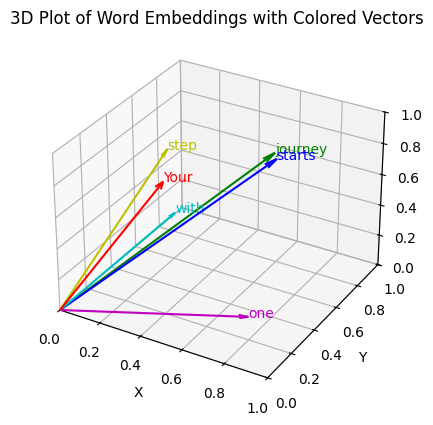

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55] # step     (x^6)
   ]
)

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()


# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()


<div class="alert alert-block alert-info">
    
Each row represents a word, and each column represents an embedding dimension
    
</div>

<div class="alert alert-block alert-info">
    
The second input token serves as the query    
</div>

In [58]:
query = inputs[1]  # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


<div class="alert alert-block alert-success">

In the next step, we normalize each of the attention scores that
we computed previously.

</div>

<div class="alert alert-block alert-success">

The main goal behind the normalization  is to obtain attention weights
that sum up to 1.

This normalization is a convention that is useful for interpretation and for
maintaining training stability in an LLM.

Here's a straightforward method for achieving this
normalization step:

</div>

In [59]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


<div class="alert alert-block alert-info">
    
In practice, it's more common and advisable to use the softmax function for normalization.

This approach is better at managing extreme values and offers more favorable gradient
properties during training.

Below is a basic implementation of the softmax function for
normalizing the attention scores:
</div>

In [60]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


<div class="alert alert-block alert-info">
    
As the output shows, the softmax function also meets the objective and normalizes the
attention weights such that they sum to 1:
</div>

<div class="alert alert-block alert-warning">

In addition, the softmax function ensures that the attention weights are always positive.
This makes the output interpretable as probabilities or relative importance, where higher
weights indicate greater importance.
    
</div>

<div class="alert alert-block alert-warning">

Note that this naive softmax implementation (softmax_naive) may encounter numerical
instability problems, such as overflow and underflow, when dealing with large or small input
values.

Therefore, in practice, it's advisable to use the PyTorch implementation of softmax,
which has been extensively optimized for performance:
    
</div>

In [61]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


<div class="alert alert-block alert-info">
    
In this case, we can see that it yields the same results as our previous softmax_naive
function:
</div>

<div class="alert alert-block alert-success">

The context vector z(2)is calculated as a weighted sum of all input
vectors.

This involves multiplying each input vector by its corresponding attention weight:

</div>

In [62]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


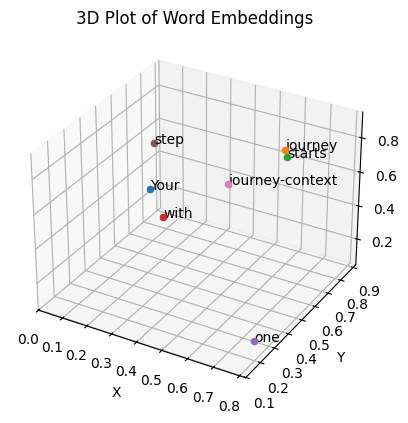

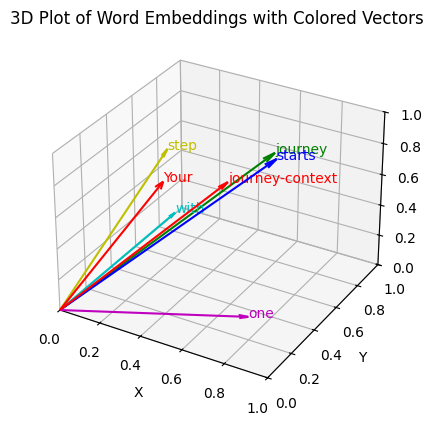

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

inputs2 = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55], # step     (x^6)
   [0.4419, 0.6515, 0.5683]]
)

# Corresponding words
words2 = ['Your', 'journey', 'starts', 'with', 'one', 'step', 'journey-context']

# Extract x, y, z coordinates
x_coords = inputs2[:, 0].numpy()
y_coords = inputs2[:, 1].numpy()
z_coords = inputs2[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words2):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'r']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words2, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()

<div class="alert alert-block alert-success">

Now, we can extend this computation to
calculate attention weights and context vectors for all inputs.

</div>

<div class="alert alert-block alert-success">

First, we add an additional for-loop to compute the
dot products for all pairs of inputs.

</div>

In [64]:
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


<div class="alert alert-block alert-info">
    
Each element in the preceding tensor represents an attention score between each pair of
inputs.
</div>

<div class="alert alert-block alert-info">
    
When computing the preceding attention score tensor, we used for-loops in Python.
                                                            
However, for-loops are generally slow, and we can achieve the same results using matrix
multiplication:
</div>

In [65]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


<div class="alert alert-block alert-success">

We now normalize each row so that the values in
each row sum to 1:

</div>

In [66]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


<div class="alert alert-block alert-warning">

In the context of using PyTorch, the dim parameter in functions like torch.softmax specifies
the dimension of the input tensor along which the function will be computed.

By setting
dim=-1, we are instructing the softmax function to apply the normalization along the last
dimension of the attn_scores tensor.

If attn_scores is a 2D tensor (for example, with a
shape of [rows, columns]), dim=-1 will normalize across the columns so that the values in
each row (summing over the column dimension) sum up to 1.
    
</div>

<div class="alert alert-block alert-success">

Let's briefly verify that
the rows indeed all sum to 1:

</div>

In [67]:
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)
print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


<div class="alert alert-block alert-success">

In the third and last step, we now use these attention weights to compute all context
vectors via matrix multiplication:

</div>

In [68]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


<div class="alert alert-block alert-success">

We can double-check that the code is correct by comparing the 2nd row with the context
vector z(2) calculated previously

</div>

In [69]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


<div class="alert alert-block alert-info">
    
Based on the result, we can see that the previously calculated context_vec_2 matches the
second row in the previous tensor exactly
</div>

<div class="alert alert-block alert-warning">

This concludes the code walkthrough of a simple self-attention mechanism.
    
</div>

## IMPLEMENTING SELF ATTENTION WITH TRAINABLE WEIGHTS

In [70]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

<div class="alert alert-block alert-success">

Let's begin by defining a few variables:

</div>

A The second input element

B The input embedding size, d=3


C The output embedding size, d_out=2

In [71]:
x_2 = inputs[1] #A
d_in = inputs.shape[1] #B
d_out = 2 #C

<div class="alert alert-block alert-info">
    
Note that in GPT-like models, the input and output dimensions are usually the same.

But for illustration purposes, to better follow the computation, we choose different input (d_in=3)
and output (d_out=2) dimensions here.

</div>

<div class="alert alert-block alert-success">

Next, we initialize the three weight matrices Wq, Wk and Wv

</div>

In [72]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [73]:
print(W_query)

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])


In [74]:
print(W_key)

Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])


In [75]:
print(W_value)

Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])


<div class="alert alert-block alert-info">
    
Note that we are setting requires_grad=False to reduce clutter in the outputs for
illustration purposes.

If we were to use the weight matrices for model training, we
would set requires_grad=True to update these matrices during model training.

</div>

<div class="alert alert-block alert-success">

Next, we compute the query, key, and value vectors as shown earlier
</div>

In [76]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


<div class="alert alert-block alert-info">
    
As we can see based on the output for the query, this results in a 2-dimensional vector.

This is because: we set the number of columns of the corresponding weight matrix, via d_out, to 2:

</div>

<div class="alert alert-block alert-success">

Even though our temporary goal is to only compute the one context vector z(2),  we still
require the key and value vectors for all input elements.

This is because they are involved in computing the attention weights with respect to the query q(2)
</div>

<div class="alert alert-block alert-success">

We can obtain all keys and values via matrix multiplication:
</div>

In [77]:
keys = inputs @ W_key
values = inputs @ W_value
queries = inputs @ W_query
print("keys.shape:", keys.shape)

print("values.shape:", values.shape)

print("queries.shape:", queries.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])
queries.shape: torch.Size([6, 2])


<div class="alert alert-block alert-info">
    
As we can tell from the outputs, we successfully projected the 6 input tokens from a 3D
onto a 2D embedding space:

</div>

<div class="alert alert-block alert-success">

First, let's compute the attention score ω22</div>

In [78]:
keys_2 = keys[1] #A
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


<div class="alert alert-block alert-success">
Again, we can generalize this computation to all attention scores via matrix multiplication:</div>

In [79]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [80]:
attn_scores = queries @ keys.T # omega
print(attn_scores)

tensor([[0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330],
        [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
        [1.2544, 1.8284, 1.7877, 1.0654, 0.5508, 1.5238],
        [0.6973, 1.0167, 0.9941, 0.5925, 0.3061, 0.8475],
        [0.6114, 0.8819, 0.8626, 0.5121, 0.2707, 0.7307],
        [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]])


<div class="alert alert-block alert-success">
    
We compute the attention weights by scaling the
attention scores and using the softmax function we used earlier.

The difference to earlier is
that we now scale the attention scores by dividing them by the square root of the
embedding dimension of the keys.

Note that taking the square root is mathematically the
same as exponentiating by 0.5:</div>

In [81]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)
print(d_k)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
2


WHY DIVIDE BY SQRT (DIMENSION)

<div class="alert alert-block alert-warning">

Reason 1: For stability in learning

The softmax function is sensitive to the magnitudes of its inputs. When the inputs are large, the differences between the exponential values of each input become much more pronounced. This causes the softmax output to become "peaky," where the highest value receives almost all the probability mass, and the rest receive very little.

In attention mechanisms, particularly in transformers, if the dot products between query and key vectors become too large (like multiplying by 8 in this example), the attention scores can become very large. This results in a very sharp softmax distribution, making the model overly confident in one particular "key." Such sharp distributions can make learning unstable,
    
</div>

In [82]:
import torch

# Define the tensor
tensor = torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])

# Apply softmax without scaling
softmax_result = torch.softmax(tensor, dim=-1)
print("Softmax without scaling:", softmax_result)

# Multiply the tensor by 8 and then apply softmax
scaled_tensor = tensor * 8
softmax_scaled_result = torch.softmax(scaled_tensor, dim=-1)
print("Softmax after scaling (tensor * 8):", softmax_scaled_result)

Softmax without scaling: tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
Softmax after scaling (tensor * 8): tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


BUT WHY SQRT?

<div class="alert alert-block alert-warning">

Reason 2: To make the variance of the dot product stable

The dot product of  Q and K increases the variance because multiplying two random numbers increases the variance.

The increase in variance grows with the dimension.

Dividing by sqrt (dimension) keeps the variance close to 1
    
</div>

In [83]:
import numpy as np

# Function to compute variance before and after scaling
def compute_variance(dim, num_trials=1000):
    dot_products = []
    scaled_dot_products = []

    # Generate multiple random vectors and compute dot products
    for _ in range(num_trials):
        q = np.random.randn(dim)
        k = np.random.randn(dim)

        # Compute dot product
        dot_product = np.dot(q, k)
        dot_products.append(dot_product)

        # Scale the dot product by sqrt(dim)
        scaled_dot_product = dot_product / np.sqrt(dim)
        scaled_dot_products.append(scaled_dot_product)

    # Calculate variance of the dot products
    variance_before_scaling = np.var(dot_products)
    variance_after_scaling = np.var(scaled_dot_products)

    return variance_before_scaling, variance_after_scaling

# For dimension 5
variance_before_5, variance_after_5 = compute_variance(5)
print(f"Variance before scaling (dim=5): {variance_before_5}")
print(f"Variance after scaling (dim=5): {variance_after_5}")

# For dimension 20
variance_before_100, variance_after_100 = compute_variance(100)
print(f"Variance before scaling (dim=100): {variance_before_100}")
print(f"Variance after scaling (dim=100): {variance_after_100}")



Variance before scaling (dim=5): 5.110494497205427
Variance after scaling (dim=5): 1.0220988994410853
Variance before scaling (dim=100): 105.53277954234518
Variance after scaling (dim=100): 1.055327795423452


<div class="alert alert-block alert-success">
    
We now compute the context vector as a weighted sum over the value
vectors.

Here, the attention weights serve as a weighting factor that weighs the respective
importance of each value vector.

We can use matrix multiplication to
obtain the output in one step:</div>

In [84]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


<div class="alert alert-block alert-success">
    
So far, we only computed a single context vector, z(2).

In the next section, we will generalize the code to compute all context vectors in the input sequence, z(1)to z (T)</div>

## IMPLEMENTING A COMPACT SELF ATTENTION PYTHON CLASS

<div class="alert alert-block alert-success">
    
In the previous sections, we have gone through a lot of steps to compute the self-attention
outputs.

This was mainly done for illustration purposes so we could go through one step at
a time.

In practice, with the LLM implementation in the next chapter in mind, it is helpful to
organize this code into a Python class as follows:
    
</div>

In [85]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

<div class="alert alert-block alert-warning">

In this PyTorch code, SelfAttention_v1 is a class derived from nn.Module, which is a
fundamental building block of PyTorch models, which provides necessary functionalities for
model layer creation and management.    
</div>

<div class="alert alert-block alert-warning">

The __init__ method initializes trainable weight matrices (W_query, W_key, and
W_value) for queries, keys, and values, each transforming the input dimension d_in to an
output dimension d_out.

</div>

<div class="alert alert-block alert-warning">

During the forward pass, using the forward method, we compute the attention scores
(attn_scores) by multiplying queries and keys, normalizing these scores using softmax.

</div>

<div class="alert alert-block alert-success">
    
Finally, we create a context vector by weighting the values with these normalized attention
scores.
    
</div>

In [86]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


<div class="alert alert-block alert-info">

Since inputs contains six embedding vectors, we get a matrix storing the six
context vectors, as shown in the above result.
</div>

<div class="alert alert-block alert-info">

As a quick check, notice how the second row ([0.3061, 0.8210]) matches the contents of
context_vec_2 in the previous section.
    
</div>

<div class="alert alert-block alert-warning">

We can improve the SelfAttention_v1 implementation further by utilizing PyTorch's
nn.Linear layers, which effectively perform matrix multiplication when the bias units are
disabled.

</div>

<div class="alert alert-block alert-warning">

Additionally, a significant advantage of using nn.Linear instead of manually
implementing nn.Parameter(torch.rand(...)) is that nn.Linear has an optimized weight
initialization scheme, contributing to more stable and effective model training.

</div>

In [87]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

<div class="alert alert-block alert-success">

You can use the SelfAttention_v2 similar to SelfAttention_v1:
    
</div>

In [88]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


<div class="alert alert-block alert-info">

Note that SelfAttention_v1 and SelfAttention_v2 give different outputs because they
use different initial weights for the weight matrices since nn.Linear uses a more
sophisticated weight initialization scheme.
    
</div>

## HIDING FUTURE WORDS WITH CAUSAL ATTENTION

<div class="alert alert-block alert-success">

Let's work with the attention scores and weights from the previous section to code the causal attention mechanism.
    
</div>

<div class="alert alert-block alert-success">

In the first step illustrated in Figure 3.20, we compute the attention weights using the
softmax function as we have done in previous sections:    
</div>


<div class="alert alert-block alert-info">

Reuse the query and key weight matrices of the SelfAttention_v2 object from the previous section for
convenience
    
</div>

In [89]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [90]:
queries = sa_v2.W_query(inputs) #A
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


<div class="alert alert-block alert-success">

We can now use PyTorch's tril function to create a mask
where the values above the diagonal are zero:

</div>

In [91]:
torch.ones(context_length, context_length)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [92]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


<div class="alert alert-block alert-success">

Now, we can multiply this mask with the attention weights to zero out the values above the
diagonal:

</div>

In [93]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


<div class="alert alert-block alert-info">

As we can see, the elements above the diagonal are successfully zeroed out
    
</div>

<div class="alert alert-block alert-success">

The third step is to renormalize the attention weights to sum up to 1 again in
each row.

We can achieve this by dividing each element in each row by the sum in each
row:

</div>

In [94]:
row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


<div class="alert alert-block alert-info">

The result is an attention weight matrix where the attention weights above the diagonal are
zeroed out and where the rows sum to 1.

</div>

<div class="alert alert-block alert-success">

While we could be technically done with implementing causal attention at this point, we can
take advantage of a mathematical property of the softmax function.

We can implement the computation of the masked attention weights more efficiently in fewer steps.

</div>

<div class="alert alert-block alert-success">

The softmax function converts its inputs into a probability distribution.

When negative
infinity values (-∞) are present in a row, the softmax function treats them as zero
probability.

(Mathematically, this is because e
-∞ approaches 0.)


We can implement this more efficient masking "trick" by creating a mask with 1's above
the diagonal and then replacing these 1's with negative infinity (-inf) values:

</div>

In [95]:
print(attn_scores)

tensor([[ 0.2899,  0.0716,  0.0760, -0.0138,  0.1344, -0.0511],
        [ 0.4656,  0.1723,  0.1751,  0.0259,  0.1771,  0.0085],
        [ 0.4594,  0.1703,  0.1731,  0.0259,  0.1745,  0.0090],
        [ 0.2642,  0.1024,  0.1036,  0.0186,  0.0973,  0.0122],
        [ 0.2183,  0.0874,  0.0882,  0.0177,  0.0786,  0.0144],
        [ 0.3408,  0.1270,  0.1290,  0.0198,  0.1290,  0.0078]],
       grad_fn=<MmBackward0>)


In [96]:
torch.triu(torch.ones(context_length, context_length))

tensor([[1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.]])

In [97]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
print(mask)

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])


In [98]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


<div class="alert alert-block alert-success">

Now, all we need to do is apply the softmax function to these masked results, and we are
done.

</div>

In [99]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


<div class="alert alert-block alert-info">

As we can see based on the output, the values in each row sum to 1, and no further
normalization is necessary.

</div>

<div class="alert alert-block alert-warning">

Masking in Transformers sets scores for future tokens to a large negative value, making their influence in the softmax calculation effectively zero.

The softmax function then recalculates attention weights only among the unmasked tokens.

This process ensures no information leakage from masked tokens, focusing the model solely on the intended data.

</div>

<div class="alert alert-block alert-warning">

We could now use the modified attention weights to compute the context vectors via
context_vec = attn_weights @ values.

However, in the next section,
we first cover another minor tweak to the causal attention mechanism that is useful for
reducing overfitting when training LLMs.

</div>

### MASKING ADDITIONAL ATTENTION WEIGHTS WITH DROPOUT

<div class="alert alert-block alert-success">

In the following code example, we use a dropout rate of 50%, which means masking out
half of the attention weights.

When we train the GPT model in later chapters, we will use a
lower dropout rate, such as 0.1 or 0.2.
</div>

<div class="alert alert-block alert-success">

In the following code, we apply PyTorch's dropout implementation first to a 6×6 tensor
consisting of ones for illustration purposes:
</div>

In [100]:
example = torch.ones(6, 6) #B
print(example)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])


In [101]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) #A
example = torch.ones(6, 6) #B
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


<div class="alert alert-block alert-info">

When applying dropout to an attention weight matrix with a rate of 50%, half of the
elements in the matrix are randomly set to zero.

To compensate for the reduction in active
elements, the values of the remaining elements in the matrix are scaled up by a factor of
1/0.5 =2.

This scaling is crucial to maintain the overall balance of the attention weights,
ensuring that the average influence of the attention mechanism remains consistent during
both the training and inference phases.
</div>

<div class="alert alert-block alert-success">

Now, let's apply dropout to the attention weight matrix itself:

</div>

In [102]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


<div class="alert alert-block alert-info">

As we can see above, the resulting attention weight matrix now has additional elements zeroed out and the
remaining ones rescaled.
    
</div>

<div class="alert alert-block alert-warning">

Having gained an understanding of causal attention and dropout masking, we will
develop a concise Python class in the following section.

This class is designed to facilitate
the efficient application of these two techniques.

</div>

### IMPLEMENTING A COMPACT CAUSAL ATTENTION CLASS

<div class="alert alert-block alert-success">

In this section, we will now incorporate the causal attention and dropout modifications into
the SelfAttention Python class we developed in section 3.4.

This class will then serve as a
template for developing multi-head attention in the upcoming section.

</div>

<div class="alert alert-block alert-success">

Before we begin, one more thing is to ensure that the code can handle batches
consisting of more than one input.

This will ensure that the CausalAttention class supports the batch
outputs produced by the data loader we implemented earlier.

</div>

<div class="alert alert-block alert-success">

For simplicity, to simulate such batch inputs, we duplicate the input text example:

</div>

<div class="alert alert-block alert-info">

 2 inputs with 6 tokens each, and each token has embedding dimension 3
    
</div>

In [103]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


<div class="alert alert-block alert-info">

This results in a 3D tensor consisting of 2 input texts with 6 tokens each, where each token
is a 3-dimensional embedding vector.
    
</div>

<div class="alert alert-block alert-success">

The following CausalAttention class is similar to the SelfAttention class we
implemented earlier, except that we now added the dropout and causal mask components
as highlighted in the following code.
    
</div>

<div class="alert alert-block alert-info">

Step 1: Compared to the previous SelfAttention_v1 class, we added a dropout layer.
    
Step 2: The register_buffer call is also a new addition (more information is provided in the following text).

Step 3:  We transpose dimensions 1 and 2, keeping the batch dimension at the first position (0).

Step 4: In PyTorch, operations with a trailing underscore are performed in-place, avoiding unnecessary memory
copies
    
</div>

In [104]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

<div class="alert alert-block alert-warning">

The use of register_buffer in
PyTorch is not strictly necessary for all use cases but offers several advantages here.

For
instance, when we use the CausalAttention class in our LLM, buffers are automatically
moved to the appropriate device (CPU or GPU) along with our model, which will be relevant
when training the LLM in future chapters.

This means we don't need to manually ensure
these tensors are on the same device as your model parameters, avoiding device mismatch
errors.

</div>

<div class="alert alert-block alert-success">

We can use the CausalAttention class as follows, similar to SelfAttention previously:
    
</div>

In [105]:
print(d_in)

3


In [106]:
print(d_out)

2


In [107]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


In [108]:
print(context_vecs)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)


<div class="alert alert-block alert-info">

As we can see, the resulting context vector is a 3D tensor where each token is now represented by a 2D
embedding:
    
</div>

<div class="alert alert-block alert-warning">

In the next section, we will expand on this concept
and implement a multi-head attention module, that implements several of such causal
attention mechanisms in parallel.

</div>

## EXTENDING SINGLE HEAD ATTENTION TO MULTI-HEAD ATTENTION

<div class="alert alert-block alert-success">
In practical terms, implementing multi-head attention involves creating multiple instances
of the self-attention mechanism, each with
its own weights, and then combining their outputs
    
</div>

<div class="alert alert-block alert-success">
In code, we can achieve this by implementing a simple MultiHeadAttentionWrapper
class that stacks multiple instances of our previously implemented CausalAttention
module:
    
</div>

In [109]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)


<div class="alert alert-block alert-info">

For example, if we use this MultiHeadAttentionWrapper class with two attention heads (via
num_heads=2) and CausalAttention output dimension d_out=2, this results in a 4-
dimensional context vectors (d_out*num_heads=4)
    
</div>

<div class="alert alert-block alert-success">
To illustrate further with a concrete example, we can use the
MultiHeadAttentionWrapper class similar to the CausalAttention class before:
</div>

In [110]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [111]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens = 6
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


<div class="alert alert-block alert-info">

The first dimension of the resulting context_vecs tensor is 2 since we have two input texts
(the input texts are duplicated, which is why the context vectors are exactly the same for
those).

The second dimension refers to the 6 tokens in each input. The third dimension
refers to the 4-dimensional embedding of each token.
    
</div>

<div class="alert alert-block alert-success">
In this section, we implemented a MultiHeadAttentionWrapper that combined multiple
single-head attention modules.

However, note that these are processed sequentially via
[head(x) for head in self.heads] in the forward method.

We can improve this
implementation by processing the heads in parallel.

One way to achieve this is by
computing the outputs for all attention heads simultaneously via matrix multiplication, as
we will explore in the next section.
</div>

### IMPLEMENTING MULTI-HEAD ATTENTION WITH WEIGHT SPLITS

<div class="alert alert-block alert-warning">
    
Instead of maintaining two separate classes, MultiHeadAttentionWrapper and
CausalAttention, we can combine both of these concepts into a single
MultiHeadAttention class.

Also, in addition to just merging the
MultiHeadAttentionWrapper with the CausalAttention code, we will make some other
modifications to implement multi-head attention more efficiently.
</div>

<div class="alert alert-block alert-warning">
    
In the MultiHeadAttentionWrapper, multiple heads are implemented by creating a list
of CausalAttention objects (self.heads), each representing a separate attention head.


The CausalAttention class independently performs the attention mechanism, and the
results from each head are concatenated.

In contrast, the following MultiHeadAttention
class integrates the multi-head functionality within a single class.


It splits the input into
multiple heads by reshaping the projected query, key, and value tensors and then combines
the results from these heads after computing attention.
</div>

<div class="alert alert-block alert-success">

Let's take a look at the MultiHeadAttention class before we discuss it further:
</div>

In [112]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

<div class="alert alert-block alert-info">

Step 1: Reduce the projection dim to match desired output dim

Step 2: Use a Linear layer to combine head outputs

Step 3: Tensor shape: (b, num_tokens, d_out)

Step 4: We implicitly split the matrix by adding a `num_heads` dimension. Then we unroll last dim: (b,
num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)

Step 5: Transpose from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)

Step 6: Compute dot product for each head

Step 7: Mask truncated to the number of tokens

Step 8: Use the mask to fill attention scores

Step 9: Tensor shape: (b, num_tokens, n_heads, head_dim)

Step 10: Combine heads, where self.d_out = self.num_heads * self.head_dim

Step 11: Add an optional linear projection
</div>

<div class="alert alert-block alert-warning">

Even though the reshaping (.view) and transposing (.transpose) of tensors inside the
MultiHeadAttention class looks very complicated, mathematically, the
MultiHeadAttention class implements the same concept as the
MultiHeadAttentionWrapper earlier.

</div>

<div class="alert alert-block alert-warning">

On a big-picture level, in the previous MultiHeadAttentionWrapper, we stacked
multiple single-head attention layers that we combined into a multi-head attention layer.


The MultiHeadAttention class takes an integrated approach.

It starts with a multi-head
layer and then internally splits this layer into individual attention heads

</div>

#### DETAILED EXPLANATION OF THE MULTI-HEAD ATTENTION CLASS

<div class="alert alert-block alert-success">

The splitting of the query, key, and value tensors, is achieved
through tensor reshaping and transposing operations using PyTorch's .view and
.transpose methods.

The input is first transformed (via linear layers for queries, keys, and
values) and then reshaped to represent multiple heads.

</div>

<div class="alert alert-block alert-success">

The key operation is to split the d_out dimension into num_heads and head_dim, where
head_dim = d_out / num_heads.

This splitting is then achieved using the .view method: a
tensor of dimensions (b, num_tokens, d_out) is reshaped to dimension (b, num_tokens,
num_heads, head_dim).
</div>

<div class="alert alert-block alert-success">

The tensors are then transposed to bring the num_heads dimension before the
num_tokens dimension, resulting in a shape of (b, num_heads, num_tokens, head_dim).

This transposition is crucial for correctly aligning the queries, keys, and values across the
different heads and performing batched matrix multiplications efficiently.
</div>

<div class="alert alert-block alert-success">

To illustrate this batched matrix multiplication, suppose we have the following example
tensor:

</div>

<div class="alert alert-block alert-warning">

Continuing with MultiHeadAttention, after computing the attention weights and context
vectors, the context vectors from all heads are transposed back to the shape (b,
num_tokens, num_heads, head_dim).

These vectors are then reshaped (flattened) into the
shape (b, num_tokens, d_out), effectively combining the outputs from all heads

</div>

<div class="alert alert-block alert-warning">

Additionally, we added a so-called output projection layer (self.out_proj) to
MultiHeadAttention after combining the heads, which is not present in the
CausalAttention class.

This output projection layer is not strictly necessary, but it is commonly used in many LLM
architectures, which is why we added it here for completeness.

</div>

<div class="alert alert-block alert-warning">

Even though the MultiHeadAttention class looks more complicated than the
MultiHeadAttentionWrapper due to the additional reshaping and transposition of tensors,
it is more efficient.

The reason is that we only need one matrix multiplication to compute
the keys, for instance, keys = self.W_key(x) (the same is true for the queries and
values).
                                              

In the MultiHeadAttentionWrapper, we needed to repeat this matrix multiplication,
which is computationally one of the most expensive steps, for each attention head.

</div>

<div class="alert alert-block alert-success">

The MultiHeadAttention class can be used similar to the SelfAttention and
CausalAttention classes we implemented earlier:
</div>

In [113]:
torch.manual_seed(123)

# Define the tensor with 3 rows and 6 columns
inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],  # Row 1
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],  # Row 2
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]  # Row 3
)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

batch_size, context_length, d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

torch.Size([2, 3, 6])
tensor([[[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]],

        [[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]]],
       grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 3, 6])


<div class="alert alert-block alert-info">

As we can see based on the results, the output dimension is directly controlled by the
d_out argument:

</div>

<div class="alert alert-block alert-warning">

In this section, we implemented the MultiHeadAttention class that we will use in the
upcoming sections when implementing and training the LLM itself.


Note that while the code is fully functional, we used relatively small embedding sizes and numbers of attention
heads to keep the outputs readable.

</div>

<div class="alert alert-block alert-warning">

For comparison, the smallest GPT-2 model (117 million parameters) has 12 attention
heads and a context vector embedding size of 768.

The largest GPT-2 model (1.5 billion
parameters) has 25 attention heads and a context vector embedding size of 1600.

Note
that the embedding sizes of the token inputs and context embeddings are the same in GPT
models (d_in = d_out).

</div>

## IMPLEMENTING A GPT MODEL FROM SCRATCH TO GENERATE TEXT

In [114]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

## GPT ARCHITECTURE PART 1: DUMMY GPT MODEL CLASS

<div class="alert alert-block alert-info">

Step 1: Use a placeholder for TransformerBlock

Step 2: Use a placeholder for LayerNorm
</div>

In [115]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

<div class="alert alert-block alert-warning">

The DummyGPTModel class in this code defines a simplified version of a GPT-like model using
PyTorch's neural network module (nn.Module).

The model architecture in the
DummyGPTModel class consists of token and positional embeddings, dropout, a series of
transformer blocks (DummyTransformerBlock), a final layer normalization
(DummyLayerNorm), and a linear output layer (out_head).

The configuration is passed in via
a Python dictionary, for instance, the GPT_CONFIG_124M dictionary we created earlier.

</div>

<div class="alert alert-block alert-warning">
    
The forward method describes the data flow through the model: it computes token and
positional embeddings for the input indices, applies dropout, processes the data through
the transformer blocks, applies normalization, and finally produces logits with the linear
output layer.

</div>

<div class="alert alert-block alert-warning">

The code above is already functional, as we will see later in this section after we prepare
the input data.

However, for now, note in the code above that we have used placeholders
(DummyLayerNorm and DummyTransformerBlock) for the transformer block and layer
normalization, which we will develop in later sections

</div>

<div class="alert alert-block alert-success">

Next, we will prepare the input data and initialize a new GPT model to illustrate its
usage.

</div>

### STEP 1: TOKENIZATION

In [116]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


### STEP 2: CREATE AN INSTANCE OF DUMMYGPTMODEL

In [117]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


<div class="alert alert-block alert-warning">

The output tensor has two rows corresponding to the two text samples. Each text sample
consists of 4 tokens; each token is a 50,257-dimensional vector, which matches the size of
the tokenizer's vocabulary.


The embedding has 50,257 dimensions because each of these dimensions refers to a
unique token in the vocabulary. At the end of this chapter, when we implement the
postprocessing code, we will convert these 50,257-dimensional vectors back into token IDs,
which we can then decode into words.

</div>

<div class="alert alert-block alert-warning">

Now that we have taken a top-down look at the GPT architecture and its in- and outputs,
we will code the individual placeholders in the upcoming sections, starting with the real
layer normalization class that will replace the DummyLayerNorm in the previous code.
</div>

## GPT ARCHITECTURE PART 2: LAYER NORMALIZATION

#### Explanation with a simple example

In [118]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) #A
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


<div class="alert alert-block alert-info">

The neural network layer we have coded consists of a Linear layer followed by a non-linear
activation function, ReLU (short for Rectified Linear Unit), which is a standard activation
function in neural networks.

If you are unfamiliar with ReLU, it simply thresholds negative
inputs to 0, ensuring that a layer outputs only positive values, which explains why the
resulting layer output does not contain any negative values.

(Note that we will use another,
more sophisticated activation function in GPT, which we will introduce in the next section).
</div>

<div class="alert alert-block alert-success">

Before we apply layer normalization to these outputs, let's examine the mean and
variance:

</div>

In [119]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-warning">

The first row in the mean tensor above contains the mean value for the first input row, and
the second output row contains the mean for the second input row.
</div>

<div class="alert alert-block alert-warning">

Using keepdim=True in operations like mean or variance calculation ensures that the
output tensor retains the same number of dimensions as the input tensor, even though the
operation reduces the tensor along the dimension specified via dim.

For instance, without
keepdim=True, the returned mean tensor would be a 2-dimensional vector [0.1324,
0.2170] instead of a 2×1-dimensional matrix [[0.1324], [0.2170]].
</div>

<div class="alert alert-block alert-warning">

For a 2D tensor (like a matrix), using dim=-1 for operations such as
mean or variance calculation is the same as using dim=1.

This is because -1 refers to the
tensor's last dimension, which corresponds to the columns in a 2D tensor.

Later, when
adding layer normalization to the GPT model, which produces 3D tensors with shape
[batch_size, num_tokens, embedding_size], we can still use dim=-1 for normalization
across the last dimension, avoiding a change from dim=1 to dim=2.

</div>

<div class="alert alert-block alert-success">

Next, let us apply layer normalization to the layer outputs we obtained earlier. The
operation consists of subtracting the mean and dividing by the square root of the variance
(also known as standard deviation):

</div>

In [120]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-info">

Note that the value 2.9802e-08 in the output tensor is the scientific notation for 2.9802 ×
10-8, which is 0.0000000298 in decimal form. This value is very close to 0, but it is not
exactly 0 due to small numerical errors that can accumulate because of the finite precision
with which computers represent numbers.
</div>

<div class="alert alert-block alert-success">

To improve readability, we can also turn off the scientific notation when printing tensor
values by setting sci_mode to False:
</div>

In [121]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-success">

Let's now encapsulate this process in a PyTorch module that we can use in the GPT
model later:
</div>

In [122]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

<div class="alert alert-block alert-warning">

This specific implementation of layer Normalization operates on the last dimension of the
input tensor x, which represents the embedding dimension (emb_dim).

The variable eps is a
small constant (epsilon) added to the variance to prevent division by zero during
normalization.

The scale and shift are two trainable parameters (of the same dimension
as the input) that the LLM automatically adjusts during training if it is determined that
doing so would improve the model's performance on its training task.

This allows the model
to learn appropriate scaling and shifting that best suit the data it is processing.

</div>

_A small note on biased variance_

<div class="alert alert-block alert-info">

In our variance calculation method, we have opted for an implementation detail by
setting unbiased=False.

For those curious about what this means, in the variance
calculation, we divide by the number of inputs n in the variance formula.

This approach does not apply Bessel's correction, which typically uses n-1 instead of n in
the denominator to adjust for bias in sample variance estimation.

This decision results in a so-called biased estimate of the variance.

For large-scale language
models (LLMs), where the embedding dimension n is significantly large, the
difference between using n and n-1 is practically negligible.

We chose this approach to ensure compatibility with the GPT-2 model's normalization layers and because it
reflects TensorFlow's default behavior, which was used to implement the original GPT2 model.
</div>

<div class="alert alert-block alert-success">

Let's now try the LayerNorm module in practice and apply it to the batch input:
</div>

In [123]:
print(batch_example)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])


In [124]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<div class="alert alert-block alert-info">

As we can see based on the results, the layer normalization code works as expected and
normalizes the values of each of the two inputs such that they have a mean of 0 and a
variance of 1:
</div>

## GPT ARCHITECTURE PART 3: FEEDFORWARD NEURAL NETWORK WITH GELU ACTIVATION

<div class="alert alert-block alert-success">

Let's implement the GELU activation function approximation used by GPT-2:
</div>

In [125]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

<div class="alert alert-block alert-success">

To get an idea of what this GELU function looks like and how it compares to the ReLU
function, let's plot these functions side by side:
</div>

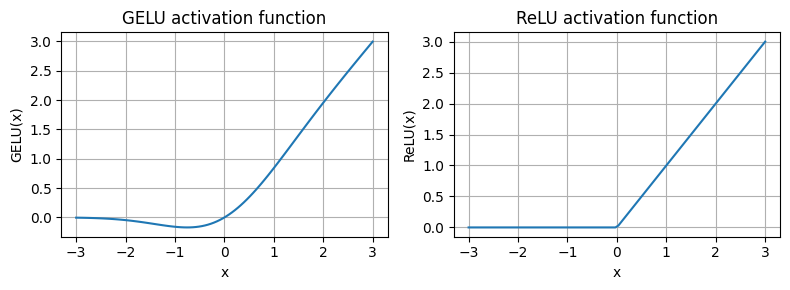

In [126]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-info">

As we can see in the resulting plot, ReLU is a piecewise linear function that
outputs the input directly if it is positive; otherwise, it outputs zero.

GELU is a smooth, nonlinear function that approximates ReLU but with a non-zero gradient for negative values.
</div>

<div class="alert alert-block alert-warning">

The smoothness of GELU, as shown in the above figure, can lead to better optimization properties
during training, as it allows for more nuanced adjustments to the model's parameters.

In contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder,
especially in networks that are very deep or have complex architectures.

Moreover, unlike RELU, which outputs zero for any negative input, GELU allows for a small, non-zero output
for negative values.

This characteristic means that during the training process, neurons that
receive negative input can still contribute to the learning process, albeit to a lesser extent
than positive inputs.

</div>

<div class="alert alert-block alert-success">

Next, let's use the GELU function to implement the small neural network module,
FeedForward, that we will be using in the LLM's transformer block later:
</div>

In [127]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [128]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [129]:
print(GPT_CONFIG_124M["emb_dim"])


768


<div class="alert alert-block alert-info">

As we can see in the preceding code, the FeedForward module is a small neural network
consisting of two Linear layers and a GELU activation function.

In the 124 million parameter GPT model, it receives the input batches with tokens that have an embedding
size of 768 each via the GPT_CONFIG_124M dictionary where GPT_CONFIG_124M["emb_dim"]
= 768.
</div>

<div class="alert alert-block alert-success">

Let's use the GELU function to implement the small neural network module,
FeedForward, that we will be using in the LLM's transformer block later:
</div>

In [130]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<div class="alert alert-block alert-warning">

The FeedForward module we implemented in this section plays a crucial role in enhancing
the model's ability to learn from and generalize the data.


Although the input and output dimensions of this module are the same, it internally expands the embedding dimension
into a higher-dimensional space through the first linear layer.

This expansion is followed by a non-linear GELU activation, and then a contraction back to
the original dimension with the second linear transformation.

Such a design allows for the
exploration of a richer representation space.

</div>

<div class="alert alert-block alert-warning">

Moreover, the uniformity in input and output dimensions simplifies the architecture by
enabling the stacking of multiple layers, as we will do later, without the need to adjust
dimensions between them, thus making the model more scalable.
</div>

## GPT ARCHITECTURE PART 4: SHORTCUT CONNECTIONS

<div class="alert alert-block alert-success">

Let us see how we can add shortcut connections to the forward method:
</div>

In [131]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


<div class="alert alert-block alert-info">

The code implements a deep neural network with 5 layers, each consisting of a Linear
layer and a GELU activation function.

In the forward pass, we iteratively pass the input
through the layers and optionally add the shortcut connections  if
the self.use_shortcut attribute is set to True.
</div>

<div class="alert alert-block alert-success">

Let's use this code to first initialize a neural network without shortcut connections. Here,
each layer will be initialized such that it accepts an example with 3 input values and returns
3 output values. The last layer returns a single output value:
</div>

In [132]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

<div class="alert alert-block alert-success">

Next, we implement a function that computes the gradients in the the model's backward
pass:
</div>

In [133]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

<div class="alert alert-block alert-warning">

In the preceding code, we specify a loss function that computes how close the model output
and a user-specified target (here, for simplicity, the value 0) are.

Then, when calling loss.backward(), PyTorch computes the loss gradient for each layer in the model.

We can iterate through the weight parameters via model.named_parameters().

Suppose we have a 3×3 weight parameter matrix for a given layer.

In that case, this layer will have 3×3 gradient values, and we print the mean absolute gradient of these 3×3 gradient values to
obtain a single gradient value per layer to compare the gradients between layers more
easily.
</div>

<div class="alert alert-block alert-warning">

In short, the .backward() method is a convenient method in PyTorch that computes loss
gradients, which are required during model training, without implementing the math for the
gradient calculation ourselves, thereby making working with deep neural networks much
more accessible.
</div>

<div class="alert alert-block alert-success">

Let's now use the print_gradients function and apply it to the model without skip
connections:
</div>

In [134]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


<div class="alert alert-block alert-info">
As we can see based on the output of the print_gradients function, the gradients become
smaller as we progress from the last layer (layers.4) to the first layer (layers.0), which
is a phenomenon called the vanishing gradient problem.
    
</div>

<div class="alert alert-block alert-success">
Let's now instantiate a model with skip connections and see how it compares:
</div>

In [135]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169798612594604
layers.1.0.weight has gradient mean of 0.20694111287593842
layers.2.0.weight has gradient mean of 0.3289700150489807
layers.3.0.weight has gradient mean of 0.26657330989837646
layers.4.0.weight has gradient mean of 1.3258544206619263


<div class="alert alert-block alert-info">
As we can see, based on the output, the last layer (layers.4) still has a larger gradient
than the other layers.

However, the gradient value stabilizes as we progress towards the
first layer (layers.0) and doesn't shrink to a vanishingly small value.
</div>

<div class="alert alert-block alert-warning">

In conclusion, shortcut connections are important for overcoming the limitations posed
by the vanishing gradient problem in deep neural networks.

Shortcut connections are a core building block of very large models such as LLMs, and they will help facilitate more effective
training by ensuring consistent gradient flow across layers when we train the GPT model
</div>

## GPT ARCHITECTURE PART 5: CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK

In [136]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

### THE BUILDING BLOCKS: LAYER NORMALIZATION, GELU AND FEED-FORWARD NEURAL NETWORK

In [137]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

<div class="alert alert-block alert-success">
Let us code a transformer block as follows:
</div>

<div class="alert alert-block alert-info">

Step 1: Shortcut connection for attention block

Step 2:  Shortcut connection for feed forward block

Step 3: Add the original input back
</div>

In [138]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

<div class="alert alert-block alert-warning">

The given code defines a TransformerBlock class in PyTorch that includes a multi-head
attention mechanism (MultiHeadAttention) and a feed forward network (FeedForward),
both configured based on a provided configuration dictionary (cfg), such as
GPT_CONFIG_124M
</div>

<div class="alert alert-block alert-warning">

Layer normalization (LayerNorm) is applied before each of these two components, and
dropout is applied after them to regularize the model and prevent overfitting.

This is also known as Pre-LayerNorm.

Older architectures, such as the original transformer model,
applied layer normalization after the self-attention and feed-forward networks instead,
known as Post-LayerNorm, which often leads to worse training dynamics.
</div>

<div class="alert alert-block alert-warning">

The class also implements the forward pass, where each component is followed by a
shortcut connection that adds the input of the block to its output. This critical feature helps
gradients flow through the network during training and improves the learning of deep
models
</div>

<div class="alert alert-block alert-success">
Using the GPT_CONFIG_124M dictionary we defined earlier, let's instantiate a transformer
block and feed it some sample data
</div>

<div class="alert alert-block alert-info">

Create sample input of shape [batch_size, num_tokens, emb_dim]
</div>

In [139]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<div class="alert alert-block alert-info">

As we can see from the code output, the transformer block maintains the input dimensions
in its output, indicating that the transformer architecture processes sequences of data
without altering their shape throughout the network.
</div>

<div class="alert alert-block alert-warning">
    
The preservation of shape throughout the transformer block architecture is not incidental
but a crucial aspect of its design.

This design enables its effective application across a wide
range of sequence-to-sequence tasks, where each output vector directly corresponds to an
input vector, maintaining a one-to-one relationship.
</div>

<div class="alert alert-block alert-warning">

However, the output is a context vector
that encapsulates information from the entire input sequence.

This means that while the physical dimensions of the sequence (length and feature size)
remain unchanged as it passes through the transformer block, the content of each output
vector is re-encoded to integrate contextual information from across the entire input
sequence.

</div>

## GPT ARCHITECTURE PART 6: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTATION

In [140]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

<div class="alert alert-block alert-success">
We started with this: A dummy GPT model class
</div>

In [141]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

<div class="alert alert-block alert-success">
Then, we coded the Layer Normalization class, Feedforward Neural Network class and also the Transformer class
</div>

<div class="alert alert-block alert-warning">
    
LAYER NORMALIZATION AND FEEDFORWARD NEURAL NETWORK CLASS
</div>

In [142]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

<div class="alert alert-block alert-warning">
    
TRANSFORMER CLASS
</div>

In [143]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

<div class="alert alert-block alert-success">
Now, let us use all this knowledge and code the entire GPT architecture
</div>

In [144]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

<div class="alert alert-block alert-warning">
    
The __init__ constructor of this GPTModel class initializes the token and positional
embedding layers using the configurations passed in via a Python dictionary, cfg.

These
embedding layers are responsible for converting input token indices into dense vectors and
adding positional information.
</div>

<div class="alert alert-block alert-warning">
    
Next, the __init__ method creates a sequential stack of TransformerBlock modules
equal to the number of layers specified in cfg.

Following the transformer blocks, a
LayerNorm layer is applied, standardizing the outputs from the transformer blocks to
stabilize the learning process.

Finally, a linear output head without bias is defined, which
projects the transformer's output into the vocabulary space of the tokenizer to generate
logits for each token in the vocabulary.
</div>

<div class="alert alert-block alert-warning">
    
The forward method takes a batch of input token indices, computes their embeddings,
applies the positional embeddings, passes the sequence through the transformer blocks,
normalizes the final output, and then computes the logits, representing the next token's
unnormalized probabilities. We will convert these logits into tokens and text outputs in the
next section.
</div>

<div class="alert alert-block alert-success">
Let's now initialize the 124 million parameter GPT model using the GPT_CONFIG_124M
dictionary we pass into the cfg parameter and feed it with the batch text input we created
at the beginning of this chapter:
</div>

In [145]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


<div class="alert alert-block alert-info">

As we can see, the output tensor has the shape [2, 4, 50257], since we passed in 2 input
texts with 4 tokens each. The last dimension, 50,257, corresponds to the vocabulary size of
the tokenizer. In the next section, we will see how to convert each of these 50,257-
dimensional output vectors back into tokens.
    
</div>

<div class="alert alert-block alert-success">
Using the numel() method, short for "number of elements," we can collect the total
number of parameters in the model's parameter tensors:
</div>

In [146]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


<div class="alert alert-block alert-danger">
Earlier, we spoke of initializing a 124
million parameter GPT model, so why is the actual number of parameters 163 million, as
shown in the preceding code output?
</div>

<div class="alert alert-block alert-warning">
    
The reason is a concept called weight tying that is used in the original GPT-2
architecture, which means that the original GPT-2 architecture is reusing the weights from
the token embedding layer in its output layer.

To understand what this means, let's take a
look at the shapes of the token embedding layer and linear output layer that we initialized
on the model via the GPTModel earlier:

</div>

In [147]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


<div class="alert alert-block alert-info">

As we can see based on the print outputs, the weight tensors for both these layers have the
same shape:
</div>

<div class="alert alert-block alert-success">
The token embedding and output layers are very large due to the number of rows for the
50,257 in the tokenizer's vocabulary. Let's remove the output layer parameter count from
the total GPT-2 model count according to the weight tying:
</div>

In [148]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


<div class="alert alert-block alert-info">

As we can see, the model is now only 124 million parameters large, matching the original
size of the GPT-2 model.
</div>

<div class="alert alert-block alert-warning">
    
Weight tying reduces the overall memory footprint and computational complexity of the
model. However, in my experience, using separate token embedding and output layers
results in better training and model performance; hence, we are using separate layers in
our GPTModel implementation. The same is true for modern LLMs.

</div>

<div class="alert alert-block alert-success">
Lastly, let us compute the memory requirements of the 163 million parameters in our
GPTModel object:
</div>

In [149]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


<div class="alert alert-block alert-warning">
    
In conclusion, by calculating the memory requirements for the 163 million parameters in
our GPTModel object and assuming each parameter is a 32-bit float taking up 4 bytes, we
find that the total size of the model amounts to 621.83 MB, illustrating the relatively large
storage capacity required to accommodate even relatively small LLMs.

</div>

<div class="alert alert-block alert-warning">
    
In this section, we implemented the GPTModel architecture and saw that it outputs
numeric tensors of shape [batch_size, num_tokens, vocab_size]. In the next section,
we will write the code to convert these output tensors into text.

</div>

## GPT ARCHITECTURE PART 7: GENERATING TEXT FROM OUTPUT TOKENS

<div class="alert alert-block alert-success">
Let us implement the token-generation process as follows:
</div>

<div class="alert alert-block alert-info">

Step 1: idx is a (batch, n_tokens) array of indices in the current context

Step 2: Crop current context if it exceeds the supported context size E.g., if LLM supports only 5 tokens, and the
context size is 10 then only the last 5 tokens are used as context

Step 3: Focus only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)

Step 4: probas has shape (batch, vocab_size)

Step 5: idx_next has shape (batch, 1)

Step 6: Append sampled index to the running sequence, where idx has shape (batch, n_tokens+1)

</div>

In [150]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])

    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

<div class="alert alert-block alert-warning">
    
In the preceeding code, the generate_text_simple function, we use a softmax function to
convert the logits into a probability distribution from which we identify the position with the
highest value via torch.argmax.

The softmax function is monotonic, meaning it preserves
the order of its inputs when transformed into outputs.

So, in practice, the softmax step is
redundant since the position with the highest score in the softmax output tensor is the
same position in the logit tensor.

In other words, we could apply the torch.argmax function
to the logits tensor directly and get identical results.

However, we coded the conversion to
illustrate the full process of transforming logits to probabilities, which can add additional
intuition, such as that the model generates the most likely next token, which is known as
greedy decoding.

</div>

<div class="alert alert-block alert-warning">
    
In the next chapter, when we will implement the GPT training code, we will also
introduce additional sampling techniques where we modify the softmax outputs such that
the model doesn't always select the most likely token, which introduces variability and
creativity in the generated text.
</div>

<div class="alert alert-block alert-success">
Let's now try out the generate_text_simple function with the "Hello, I am" context
as model input
</div>

<div class="alert alert-block alert-success">
First, we encode the input context into token IDs:
</div>

In [151]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


<div class="alert alert-block alert-success">
Next, we put the model into .eval() mode, which disables random components like
dropout, which are only used during training, and use the generate_text_simple function
on the encoded input tensor:
</div>

<div class="alert alert-block alert-info">

We disable dropout since we are not training the model

</div>

In [152]:
model.eval() #A
#model = GPTModel(GPT_CONFIG_124M)
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


<div class="alert alert-block alert-success">
Using the .decode method of the tokenizer, we can convert the IDs back into text:
</div>

In [153]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


<div class="alert alert-block alert-info">

As we can see, based on the preceding output, the model generated gibberish, which is not
at all coherent text.

What happened?

The reason why the model is unable to produce coherent text is that we haven't trained it yet.

So far, we just
implemented the GPT architecture and initialized a GPT model instance with initial random
weights.

</div>

## EVALUATING GENERATIVE TEXT MODELS

### GPT Model class we coded earlier

In [154]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

### Using GPT to generate text

<div class="alert alert-block alert-success">
We initialize a GPT model using the code from the previous chapter
</div>

In [155]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

<div class="alert alert-block alert-warning">
    
We reduce the context length (context_length) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens

This is so that more readers will be able to follow and execute the code examples on their laptop computer
</div>

<div class="alert alert-block alert-success">
    
Next, we use the generate_text_simple function from the previous chapter to generate text.

In addition, we define two convenience functions, text_to_token_ids and token_ids_to_text, for converting between token and text representations that we use throughout this chapter
</div>

In [156]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"



token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


<div class="alert alert-block alert-info">

As we can see above, the model does not produce good text because it has not been trained yet

How do we measure or capture what "good text" is, in a numeric form, to track it during training?

The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress

The next chapters on finetuning LLMs will also introduce additional ways to measure model quality

</div>

### Calculating the text generation loss: cross-entropy and perplexity

<div class="alert alert-block alert-info">

Suppose we have an inputs tensor containing the token IDs for 2 training examples (rows)

Corresponding to the inputs, the targets contain the desired token IDs that we want the model to generate

Notice that the targets are the inputs shifted by 1 position, as explained in chapter 2 when we implemented the data loader

</div>

In [157]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

<div class="alert alert-block alert-success">
    
Feeding the inputs to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each

Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary

Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores

</div>

In [158]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


<div class="alert alert-block alert-warning">
    
As discussed in the previous chapter, we can apply the argmax function to convert the probability scores into predicted token IDs.

The softmax function above produced a 50,257-dimensional vector for each token; the argmax function returns the position of the highest probability score in this vector, which is the predicted token ID for the given token.

Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs:                                                                                                                                                                                         
</div>

In [159]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


<div class="alert alert-block alert-success">
    
If we decode these tokens, we find that these are quite different from the tokens we want the model to predict, namely the target tokens.

That's because the model wasn't trained yet.

To train the model, we need to know how far it is away from the correct predictions (targets)

</div>

In [160]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


### Cross-entropy loss

<div class="alert alert-block alert-success">

The token probabilities corresponding to the target indices are as follows:


</div>

In [161]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([0.0001, 0.0000, 0.0000])
Text 2: tensor([0.0000, 0.0001, 0.0000])


<div class="alert alert-block alert-warning">

We want to maximize all these values, bringing them close to a probability of 1.
    
In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself.

</div>

In [162]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


<div class="alert alert-block alert-success">

Next, we compute the average log probability:
</div>

In [163]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


<div class="alert alert-block alert-info">

The goal is to make this average log probability as large as possible by optimizing the model weights.

Due to the log, the largest possible value is 0, and we are currently far away from 0.

In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0.

The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning.

</div>

In [164]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


<div class="alert alert-block alert-success">

PyTorch already implements a cross_entropy function that carries out the previous steps

Before we apply the cross_entropy function, let's check the shape of the logits and targets

</div>

In [165]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


<div class="alert alert-block alert-success">

For the cross_entropy function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:


</div>

In [166]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


<div class="alert alert-block alert-info">

Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize.
    
The cross_entropy function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized

</div>

In [167]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


### Perplexity

<div class="alert alert-block alert-success">

A concept related to the cross-entropy loss is the perplexity of an LLM.

The perplexity is simply the exponential of the cross-entropy loss.

</div>

In [168]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


<div class="alert alert-block alert-info">

The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens).

In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.
    
Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution
    
</div>

### Calculating the training and validation set losses

<div class="alert alert-block alert-success">

We use a relatively small dataset for training the LLM (in fact, only one short story)

The reasons are:

You can run the code examples in a few minutes on a laptop computer without a suitable GPU.

The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes.
    
We use a text from the public domain, which can be included in this GitHub repository without violating any usage rights or bloating the repository size.
    
For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens

At the time of this writing, the hourly cost of an 8xA100 cloud server at AWS is approximately 30 dollars.

So, via an off-the-envelope calculation, training this LLM would cost 184,320 / 8 * 30 = 690,000 dollars

Below, we use the same dataset we used in chapter 2.

</div>

In [169]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

<div class="alert alert-block alert-success">

A quick check that the text loaded ok by printing the first and last 100 words

</div>

In [170]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [171]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [172]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [173]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


<div class="alert alert-block alert-warning">

With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later).

Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training.
    
Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position    
</div>

### Implementing the DataLoader:


In [174]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [175]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}


In [176]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [177]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

<div class="alert alert-block alert-info">

We use a relatively small batch size to reduce the computational resource demand, and because the dataset is very small to begin with.

Llama 2 7B was trained with a batch size of 1024, for example.
    
</div>

<div class="alert alert-block alert-success">

An optional check that the data was loaded correctly:

</div>

In [178]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


<div class="alert alert-block alert-success">

An optional check that the data was loaded correctly:

</div>

In [179]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


### Here is the GPT Model class we coded earlier. We will need this

In [180]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

<div class="alert alert-block alert-success">

Next, we implement a utility function to calculate the cross-entropy loss of a given batch.

In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader.
</div>

In [181]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

<div class="alert alert-block alert-info">

If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code.
    
Via the device setting, we ensure that the data is loaded onto the same device as the LLM model.
    
</div>

In [182]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


## TRAINING LOOP FOR THE LLM

In [183]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

<div class="alert alert-block alert-info">

Step 1: Initialize lists to track losses and tokens seen

Step 2: Start the main training loop

Step 3: Reset loss gradients from previous batch iteration

Step 4: Calculate loss gradients

Step 5: Update model weights using loss gradients

Step 6: Optional evaluation step

Step 7: Print a sample text after each epoch
    
</div>

In [184]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

<div class="alert alert-block alert-info">

The evaluate_model function calculates the loss over the training and
validation set while ensuring the model is in evaluation mode with gradient tracking and
dropout disabled when calculating the loss over the training and validation sets
    
</div>

In [185]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

<div class="alert alert-block alert-info">

The generate_and_print_sample function is a convenience function that we use to track whether the model improves during the training.

In particular, the generate_and_print_sample function takes a text snippet (start_context) as input,
converts it into token IDs, and feeds it to the LLM to generate a text sample using the
generate_text_simple function we used earlier
    
</div>

<div class="alert alert-block alert-success">

Let's see this all in action by training a GPTModel instance for 10 epochs using an AdamW
optimizer and the train_model_simple function we defined earlier.
</div>

In [186]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

<div class="alert alert-block alert-info">

As we can see, based on the results printed during the training, the training loss improves
drastically, starting with a value of 9.781 and converging to 0.391.

The language skills of
the model have improved quite a lot. In the beginning, the model is only able to append
commas to the start context ("Every effort moves you,,,,,,,,,,,,") or repeat the
word "and".

At the end of the training, it can generate grammatically correct text.
    
</div>

<div class="alert alert-block alert-info">

Similar to the training set loss, we can see that the validation loss starts high (9.856)
and decreases during the training.

However, it never becomes as small as the training set
loss and remains at 6.372 after the 10th epoch.
    
</div>

<div class="alert alert-block alert-success">

Let's create a simple plot that shows the training and validation set losses side by side
</div>

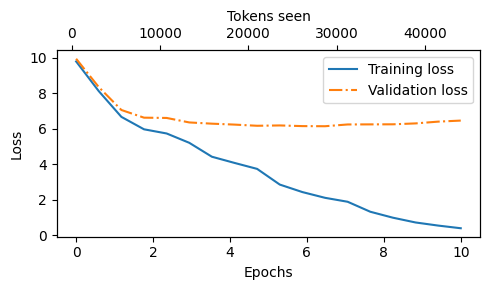

In [187]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

<div class="alert alert-block alert-warning">

Both the training and validation losses start to improve for the first
epoch. However, the losses start to diverge past the second epoch.

This divergence and the
fact that the validation loss is much larger than the training loss indicate that the model is
overfitting to the training data.

We can confirm that the model memorizes the training data
verbatim by searching for the generated text snippets, such as "quite insensible to the
irony" in the "The Verdict" text file.


This memorization is expected since we are working with a very, very small training
dataset and training the model for multiple epochs.

Usually, it's common to train a model
on a much, much larger dataset for only one epoch.   
</div>

## DECODING STRATEGIES TO CONTROL RANDOMNESS

<div class="alert alert-block alert-success">

First, we briefly revisit the generate_text_simple function
from the previous chapter that we used inside the generate_and_print_sample earlier in
this chapter.

Then, we will cover two techniques, temperature scaling, and top-k sampling,
to improve this function.
</div>

<div class="alert alert-block alert-success">

We begin by transferring the model back from the GPU to the CPU since inference with a
relatively small model does not require a GPU. Also, after training, we put the model into
evaluation model to turn off random components such as dropout:
</div>

In [188]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

<div class="alert alert-block alert-success">

Next, we plug the GPTModel instance (model) into the generate_text_simple function,
which uses the LLM to generate one token at a time:
</div>

In [189]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


### DECODING STRATEGY 1: TEMPERATURE SCALING

<div class="alert alert-block alert-success">

Previously, inside the generate_text_simple function, we always sampled the token
with the highest probability as the next token using torch.argmax, also known as greedy
decoding.

To generate text with more variety, we can replace the argmax with a function
that samples from a probability distribution (here, the probability scores the LLM generates
for each vocabulary entry at each token generation step).

</div>

<div class="alert alert-block alert-success">

To illustrate the probabilistic sampling with a concrete example, let's briefly discuss the
next-token generation process using a very small vocabulary for illustration purposes:

</div>

In [190]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

<div class="alert alert-block alert-success">

Next, assume the LLM is given the start context "every effort moves you" and
generates the following next-token logits:

</div>

In [191]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

next_token_logits2 = next_token_logits/0.1

next_token_logits3 = next_token_logits/5

<div class="alert alert-block alert-success">

As discussed in the previous chapter, inside the generate_text_simple, we convert the
logits into probabilities via the softmax function and obtain the token ID corresponding the
generated token via the argmax function, which we can then map back into text via the
inverse vocabulary:

</div>

In [192]:
probas = torch.softmax(next_token_logits2, dim=0)

print(probas)



tensor([0.0000, 0.0000, 0.0000, 0.9910, 0.0000, 0.0000, 0.0000, 0.0090, 0.0000])


In [193]:
probas = torch.softmax(next_token_logits3, dim=0)

print(probas)

tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])


In [194]:
probas = torch.softmax(next_token_logits, dim=0)

print(probas)

next_token_id = torch.argmax(probas).item()

print(next_token_id)

print(inverse_vocab[next_token_id])

tensor([0.0609, 0.0016, 0.0001, 0.5721, 0.0034, 0.0001, 0.0001, 0.3576, 0.0040])
3
forward


<div class="alert alert-block alert-success">

To implement a probabilistic sampling process, we can now replace the argmax with the
multinomial function in PyTorch:

</div>

In [195]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


<div class="alert alert-block alert-success">

The printed output is "forward" just like before. What happened? The multinomial
function samples the next token proportional to its probability score.

In other words,
"forward" is still the most likely token and will be selected by multinomial most of the
time but not all the time.

To illustrate this, let's implement a function that repeats this
sampling 1000 times:

</div>

In [196]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


<div class="alert alert-block alert-info">

As we can see based on the output, the word "forward" is sampled most of the time (582
out of 1000 times), but other tokens such as "closer", "inches", and "toward" will also
be sampled some of the time.

This means that if we replaced the argmax function with the
multinomial function inside the generate_and_print_sample function, the LLM would
sometimes generate texts such as "every effort moves you toward", "every effort
moves you inches", and "every effort moves you closer" instead of "every effort
moves you forward".
    
</div>

<div class="alert alert-block alert-success">

We can further control the distribution and selection process via a concept called
temperature scaling, where temperature scaling is just a fancy description for dividing the
logits by a number greater than 0:

</div>

<div class="alert alert-block alert-success">

Temperatures greater than 1 result in more uniformly distributed token probabilities,
and Temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions.

Let's illustrate this by plotting the original probabilities alongside
probabilities scaled with different temperature values:

</div>

In [197]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

##Multinomial

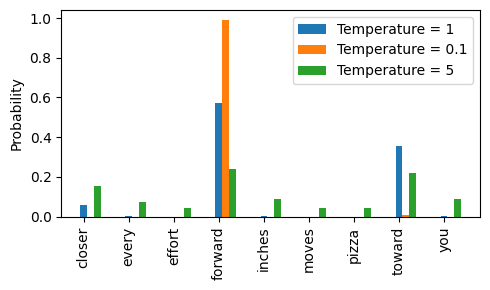

In [198]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

<div class="alert alert-block alert-info">

A temperature of 1 divides the logits by 1 before passing them to the softmax function to
compute the probability scores.

In other words, using a temperature of 1 is the same as not
using any temperature scaling.

In this case, the tokens are selected with a probability equal
to the original softmax probability scores via the multinomial sampling function in PyTorch.    
</div>

<div class="alert alert-block alert-info">

Applying very small temperatures, such as 0.1, will
result in sharper distributions such that the behavior of the multinomial function selects
the most likely token (here: "forward") almost 100% of the time, approaching the
behavior of the argmax function.

Vice versa, a temperature of 5 results in a more uniform
distribution where other tokens are selected more often.

This can add more variety to the
generated texts but also more often results in nonsensical text.

For example, using the
temperature of 5 results in texts such as "every effort moves you pizza" about 4% of
the time.
    
</div>

### DECODING STRATEGY 2: Top-k sampling

<div class="alert alert-block alert-success">

In the previous section, we implemented a probabilistic sampling approach coupled with
temperature scaling to increase the diversity of the outputs.

We saw that higher
temperature values result in more uniformly distributed next-token probabilities, which
result in more diverse outputs as it reduces the likelihood of the model repeatedly selecting
the most probable token.

This method allows for exploring less likely but potentially more
interesting and creative paths in the generation process.

However, One downside of this
approach is that it sometimes leads to grammatically incorrect or completely nonsensical
outputs such as "every effort moves you pizza".
</div>

<div class="alert alert-block alert-success">

In this section, we introduce another concept called top-k sampling, which, when
combined with probabilistic sampling and temperature scaling, can improve the text
generation results.

In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens
and exclude all other tokens from the selection process by masking their probability scores.
    
</div>

In [199]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


<div class="alert alert-block alert-success">

Subsequently, we apply PyTorch's where function to set the logit values of tokens that are
below the lowest logit value within our top-3 selection to negative infinity (-inf).
    
</div>

In [200]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


<div class="alert alert-block alert-success">

Lastly, let's apply the softmax function to turn these into next-token probabilities:
    
</div>

In [201]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### Merge Temperature Scaling and Top-k sampling

<div class="alert alert-block alert-success">

We can now apply the temperature scaling and multinomial function for probabilistic
sampling introduced in the previous section to select the next token among these 3 nonzero probability scores to generate the next token. We do this in the next section by
modifying the text generation function.

</div>

<div class="alert alert-block alert-success">

The previous two subsections introduced two concepts to increase the diversity of LLMgenerated text: temperature sampling and top-k sampling. In this section, we combine and
add these concepts to modify the generate_simple function we used to generate text via
the LLM earlier, creating a new generate function:

</div>

<div class="alert alert-block alert-info">

Step 1: For-loop is the same as before: Get logits, and only focus on last time step

Step 2: In this new section, we filter logits with top_k sampling

Step 3: This is the new section where we apply temperature scaling
    
Step 4: Carry out greedy next-token selection as before when temperature scaling is disabled

Step 5: Stop generating early if end-of-sequence token is encountered and eos_id is specified

</div>

In [202]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

<div class="alert alert-block alert-success">

Let's now see this new generate function in action:
</div>

In [209]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


<div class="alert alert-block alert-success">

As we can see, the generated text is very different from the one we previously generated
via the generate_simple function at the beginning of section 5.3 ("Every effort moves
you know," was one of the axioms he laid...!"), which was a memorized passage
from the training set.

</div>